# Anytown GNN 
#### Version: 2
#### Branch: GNN-v2

## Import

In [25]:
import wntr
import pandas as pd
import numpy as np
import pickle
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import convert
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid


## Load inp(s) into graphs

(<matplotlib.collections.PathCollection at 0x24d0b20b610>,
 <matplotlib.collections.LineCollection at 0x24d0b2109d0>)

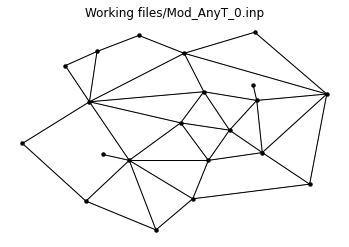

In [26]:
# Create a water network model
inp_file = 'Working files/Mod_AnyT_0.inp'
wn_current_WDS = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn_current_WDS, title=wn_current_WDS.name)


In [27]:
demands=[]
for i in wn_current_WDS.node_name_list:
    a = wn_current_WDS.get_node(i)
    try:
        demands.append(a.base_demand)
    except Exception as e:
        demands.append(-a.base_head)  #demands.append(0)
        print(e)


'Reservoir' object has no attribute 'base_demand'
'Reservoir' object has no attribute 'base_demand'


In [28]:
demands

[0.0315450982,
 0.01261803928,
 0.01261803928,
 0.01261803928,
 0.0,
 0.0315450982,
 0.0315450982,
 0.0,
 0.0315450982,
 0.0630901964,
 0.0315450982,
 0.0315450982,
 0.0,
 0.01261803928,
 0.01261803928,
 0.01261803928,
 0.01261803928,
 0.05047215712,
 0.01261803928,
 -65.532,
 -65.532]

In [29]:
a = wn_current_WDS.get_link(20)

In [30]:
lengths_pipes=[]
for i in wn_current_WDS.link_name_list:
    a = wn_current_WDS.get_link(i)
#     try:
    lengths_pipes.append(a.length)
#     except Exception as e:
#     lengths_pipes.append(-a.base_head)  #demands.append(0)
#     print(e)

In [31]:
num_pipes = len(lengths_pipes)

In [32]:
G_WDS = wn_current_WDS.get_graph() # directed multigraph

In [33]:
uG_WDS = G_WDS.to_undirected()

In [34]:
sG_WDS = nx.Graph(G_WDS)
type(sG_WDS)

networkx.classes.graph.Graph

In [35]:
sG_WDS.nodes

NodeView(('20', '30', '40', '50', '55', '60', '70', '75', '80', '90', '100', '110', '115', '120', '130', '140', '150', '160', '170', '65', '165'))

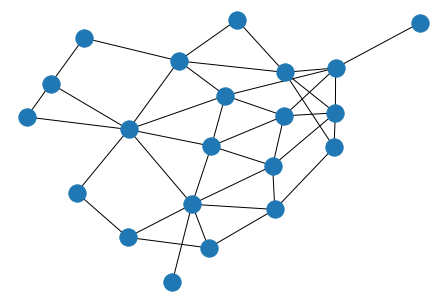

In [36]:
nx.draw(sG_WDS)

In [37]:
pg_sG_WDS = convert.from_networkx(sG_WDS)

In [38]:
pg_sG_WDS

Data(edge_index=[2, 80], pos=[21, 2], type=[80])

In [39]:
database = pickle.load( open( "Mod_AnyT_DB_trial.p", "rb" ) )

#data_list = [Data(...), ..., Data(...)]
#loader = DataLoader(data_list, batch_size=32)

In [40]:
NUM_GRAPHS = 100

In [41]:
diams_matrix = np.array([np.array(xi).T for xi in database['Diams']]).reshape(NUM_GRAPHS, num_pipes)

In [42]:
diams_matrix.shape

(100, 40)

### List of Data (graphs)

In [47]:
graphs = []

for i in range(len(diams_matrix)):
    curr_graph = pg_sG_WDS

    curr_graph.demands = torch.tensor(demands)
    curr_graph.lengths = torch.tensor(lengths_pipes)
    curr_graph.edge_attr = torch.tensor(diams_matrix[i])
    curr_graph.res_index = torch.tensor(np.array(database['avgPrPa'][i]))
    

    graphs.append(curr_graph)



In [49]:
graphs[0]

Data(demands=[21], edge_attr=[40], edge_index=[2, 80], lengths=[40], pos=[21, 2], res_index=0.16589476029750788, type=[80])

# --------------- Modifications so far (END)-------------

In [86]:
diams_matrix[0] == database['Diams'][0].T

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

In [87]:
diams_x = torch.tensor(diams_matrix, dtype=torch.double)
diams_x

tensor([[ 6.,  8.,  8.,  ..., 10., 14., 12.],
        [14., 14., 10.,  ...,  6.,  6., 14.],
        [14., 14.,  8.,  ...,  6.,  6., 12.],
        ...,
        [ 8., 12.,  6.,  ..., 12.,  6., 12.],
        [10.,  8., 12.,  ..., 10.,  8.,  6.],
        [10., 10., 14.,  ..., 10.,  6.,  8.]], dtype=torch.float64)

In [88]:
pg_sG_WDS.diams_x = diams_x

In [89]:
pg_sG_WDS

Data(diams_x=[100, 40], edge_index=[2, 80], pos=[21, 2], type=[80])

In [90]:
res_index = torch.tensor(np.array(database['avgPrPa']))
pg_sG_WDS.res_index = res_index.reshape(100,1)

In [91]:
pg_sG_WDS

Data(diams_x=[100, 40], edge_index=[2, 80], pos=[21, 2], res_index=[100, 1], type=[80])

In [92]:
size_db = len(res_index)
train = torch.tensor([ 0.7*size_db > i for i in range(size_db)])
test =torch.tensor([not i for i in train])

In [93]:
pg_sG_WDS.diams_x.type()

'torch.DoubleTensor'

In [94]:
pg_sG_WDS.train_mask = train
pg_sG_WDS.test_mask = test

In [95]:
pg_sG_WDS

Data(diams_x=[100, 40], edge_index=[2, 80], pos=[21, 2], res_index=[100, 1], test_mask=[100], train_mask=[100], type=[80])

In [111]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = GCNConv(40, 10) #number of features : 10
        self.conv2 = GCNConv(10, 1) # 10 : number of classes (It's Regression, so only one number)

    def forward(self, data):
        x, edge_index = data.diams_x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return torch.sigmoid(x)

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [113]:
model.train()
model.double()
for epoch in range(240):
    optimizer.zero_grad()
    out = model(pg_sG_WDS)
    loss = F.mse_loss(out[pg_sG_WDS.train_mask], pg_sG_WDS.res_index[pg_sG_WDS.train_mask])
    if epoch%20==0:
        print(loss)
    loss.backward()
    optimizer.step()

tensor(0.1594, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0356, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0296, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0259, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0213, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0220, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0229, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0127, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0180, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0244, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0218, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(0.0256, dtype=torch.float64, grad_fn=<MseLossBackward>)


In [114]:
model.eval()
pred = model(pg_sG_WDS)
# correct = int(pred[pg_sG_WDS.test_mask].eq(data.y[data.test_mask]).sum().item())
# acc = correct / int(data.test_mask.sum())
# print('Accuracy: {:.4f}'.format(acc))

#### Branch GNN v2